In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import date
# import proplot as pplt
import ultraplot as uplt
import sys
import os

# --- Correctly configure paths from within the 'examples' directory ---
# Get the project root directory (which is the parent of the current 'examples' directory)
project_root = os.path.dirname(os.getcwd())

# Add the path to the legacy Oliver code so Python can find it
legacy_code_dir = os.path.join(project_root, 'tests', 'data', 'legacy')
sys.path.append(legacy_code_dir)

# Now we can import everything
import marineHeatWaves as oliver_mhw
from mhw3d import bipolarMhwToolBox as ben_mhw

In [2]:
def generate_synthetic_data():
    """
    Generates a synthetic temperature time series based on the example
    in the ecjoliver/marineHeatWaves README.
    """
    # Create time vector
    t_start = date(1982, 1, 1).toordinal()
    t_end = date(2013, 12, 31).toordinal()
    time = np.arange(t_start, t_end + 1)

    # Create synthetic temperature series
    temp = 15. * np.ones(len(time))
    temp += 5. * np.cos(2 * np.pi * (time - 150) / 365.25) # Seasonal cycle
    temp += 0.2 * (time - time[0]) / (time[-1] - time[0]) # Trend
    temp += 0.5 * np.random.randn(len(time)) # Noise
    
    # Add three MHWs
    temp[1000:1050] += 4.0
    temp[4000:4100] += 3.0
    temp[8000:8050] += 5.0

    # Convert ordinal time to datetime64 for xarray/pandas
    time_datetime = np.array([date.fromordinal(t) for t in time]).astype('datetime64[ns]')

    return time_datetime, temp

## First we check that the detection algorithms produce exactly the same results (applying the benMHW detection to the Oliver thresholds)

In [3]:
# 1. Generate the data
time, temp = generate_synthetic_data()

# 2. Run the original Oliver code
t_ordinal = np.array([pd.to_datetime(t).to_pydatetime().toordinal() for t in time])
expected_events, expected_clim = oliver_mhw.detect(t_ordinal, temp)
expected_df = pd.DataFrame(expected_events)

# 3. Prepare input for YOUR toolbox
ssta = temp - expected_clim['seas']
severity = ssta / (expected_clim['thresh'] - expected_clim['seas'])

# 4. Create the xarray.Dataset for your code
ds_input_1d = xr.Dataset(
    data_vars={'ssta': (('time',), ssta), 'severity': (('time',), severity)},
    coords={'time': time}
)
ds_input = ds_input_1d.expand_dims(['lat', 'lon'])

# 5. Run YOUR code
ds_actual_events = ben_mhw.calculate_MHWs_metrics(ds_input)

# 6. Format your results into a clean DataFrame
ds_actual_events = ds_actual_events.squeeze(drop=True).dropna('event', how='all')
actual_df = pd.DataFrame({
    'date_start': ds_actual_events['date_start'].values,
    'date_end': ds_actual_events['date_end'].values,
    'date_peak': ds_actual_events['date_peak'].values,
    'duration': ds_actual_events['duration'].values,
    'intensity_max': ds_actual_events['intensity_max'].values,
    'intensity_mean': ds_actual_events['intensity_mean'].values,
    'intensity_cumulative': ds_actual_events['intensity_cumul'].values,
})


In [4]:
# Select only the columns we want to compare
columns_to_compare = actual_df.columns.tolist()

print("--- Expected Events (Oliver Method) ---")
display(expected_df[columns_to_compare])

print("\n--- Actual Events (Ben-MHW Method) ---")
display(actual_df)

--- Expected Events (Oliver Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-10-05,50,5.347997,3.721784,186.089199
1,1992-12-14,1993-03-23,1992-12-22,100,4.169782,2.867888,286.788814
2,2003-11-27,2004-01-15,2004-01-14,50,6.117553,4.715190,235.759480



--- Actual Events (Ben-MHW Method) ---


,date_start,date_end,date_peak,duration,intensity_max,intensity_mean,intensity_cumulative
0,1984-09-27,1984-11-15,1984-10-05,50.0,5.347997,3.721784,186.089199
1,1992-12-14,1993-03-23,1992-12-22,100.0,4.169782,2.867888,286.788814
2,2003-11-27,2004-01-15,2004-01-14,50.0,6.117553,4.715190,235.759480


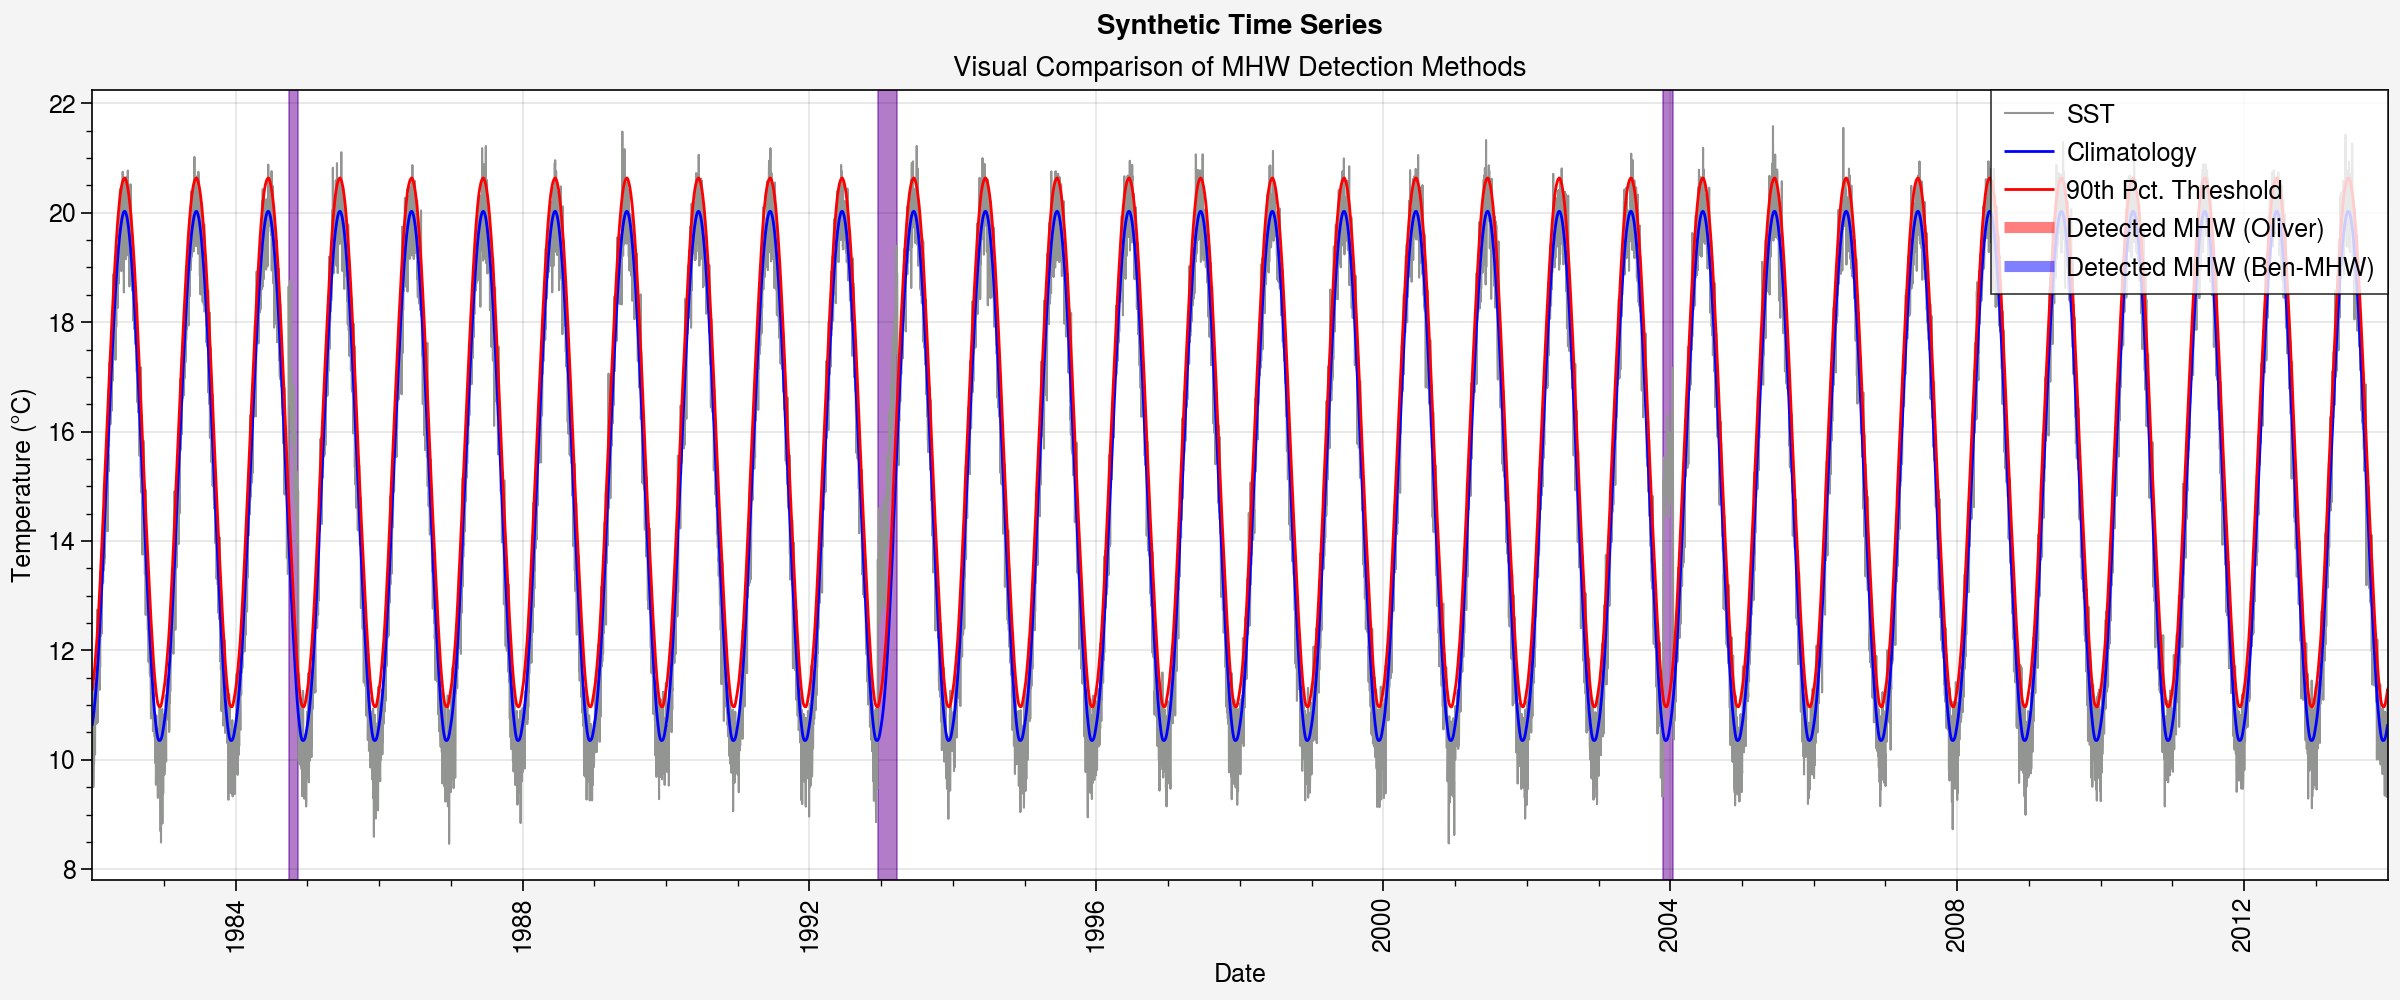

In [5]:
# Create a figure and axes for the plot
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

# Plot the full temperature time series, climatology, and threshold
ax.plot(time, temp, color='gray', lw=0.75, label='SST')
ax.plot(time, expected_clim['seas'], color='blue', lw=1, label='Climatology')
ax.plot(time, expected_clim['thresh'], color='red', lw=1, label='90th Pct. Threshold')

# Highlight the detected MHWs from both methods
# Use different colors with transparency to see the overlap
for i, event in expected_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='red', alpha=0.3)

for i, event in actual_df.iterrows():
    ax.axvspan(event['date_start'], event['date_end'], color='blue', alpha=0.3)

# Add clear legend entries
ax.plot([], [], color='red', lw=4, alpha=0.5, label='Detected MHW (Oliver)')
ax.plot([], [], color='blue', lw=4, alpha=0.5, label='Detected MHW (Ben-MHW)')

# Format the plot
ax.format(
    title='Visual Comparison of MHW Detection Methods',
    xlabel='Date',
    ylabel='Temperature (°C)',
    suptitle='Synthetic Time Series'
)
ax.legend(ncols=1, loc='upper right')

uplt.show()

## Then compare the climatologies and thresholds between the two codes:

Calculating 366-day climatology using the ben-mhw toolbox...
Calculation complete.
Summarizing the Oliver code's daily output...
Summarizing complete.


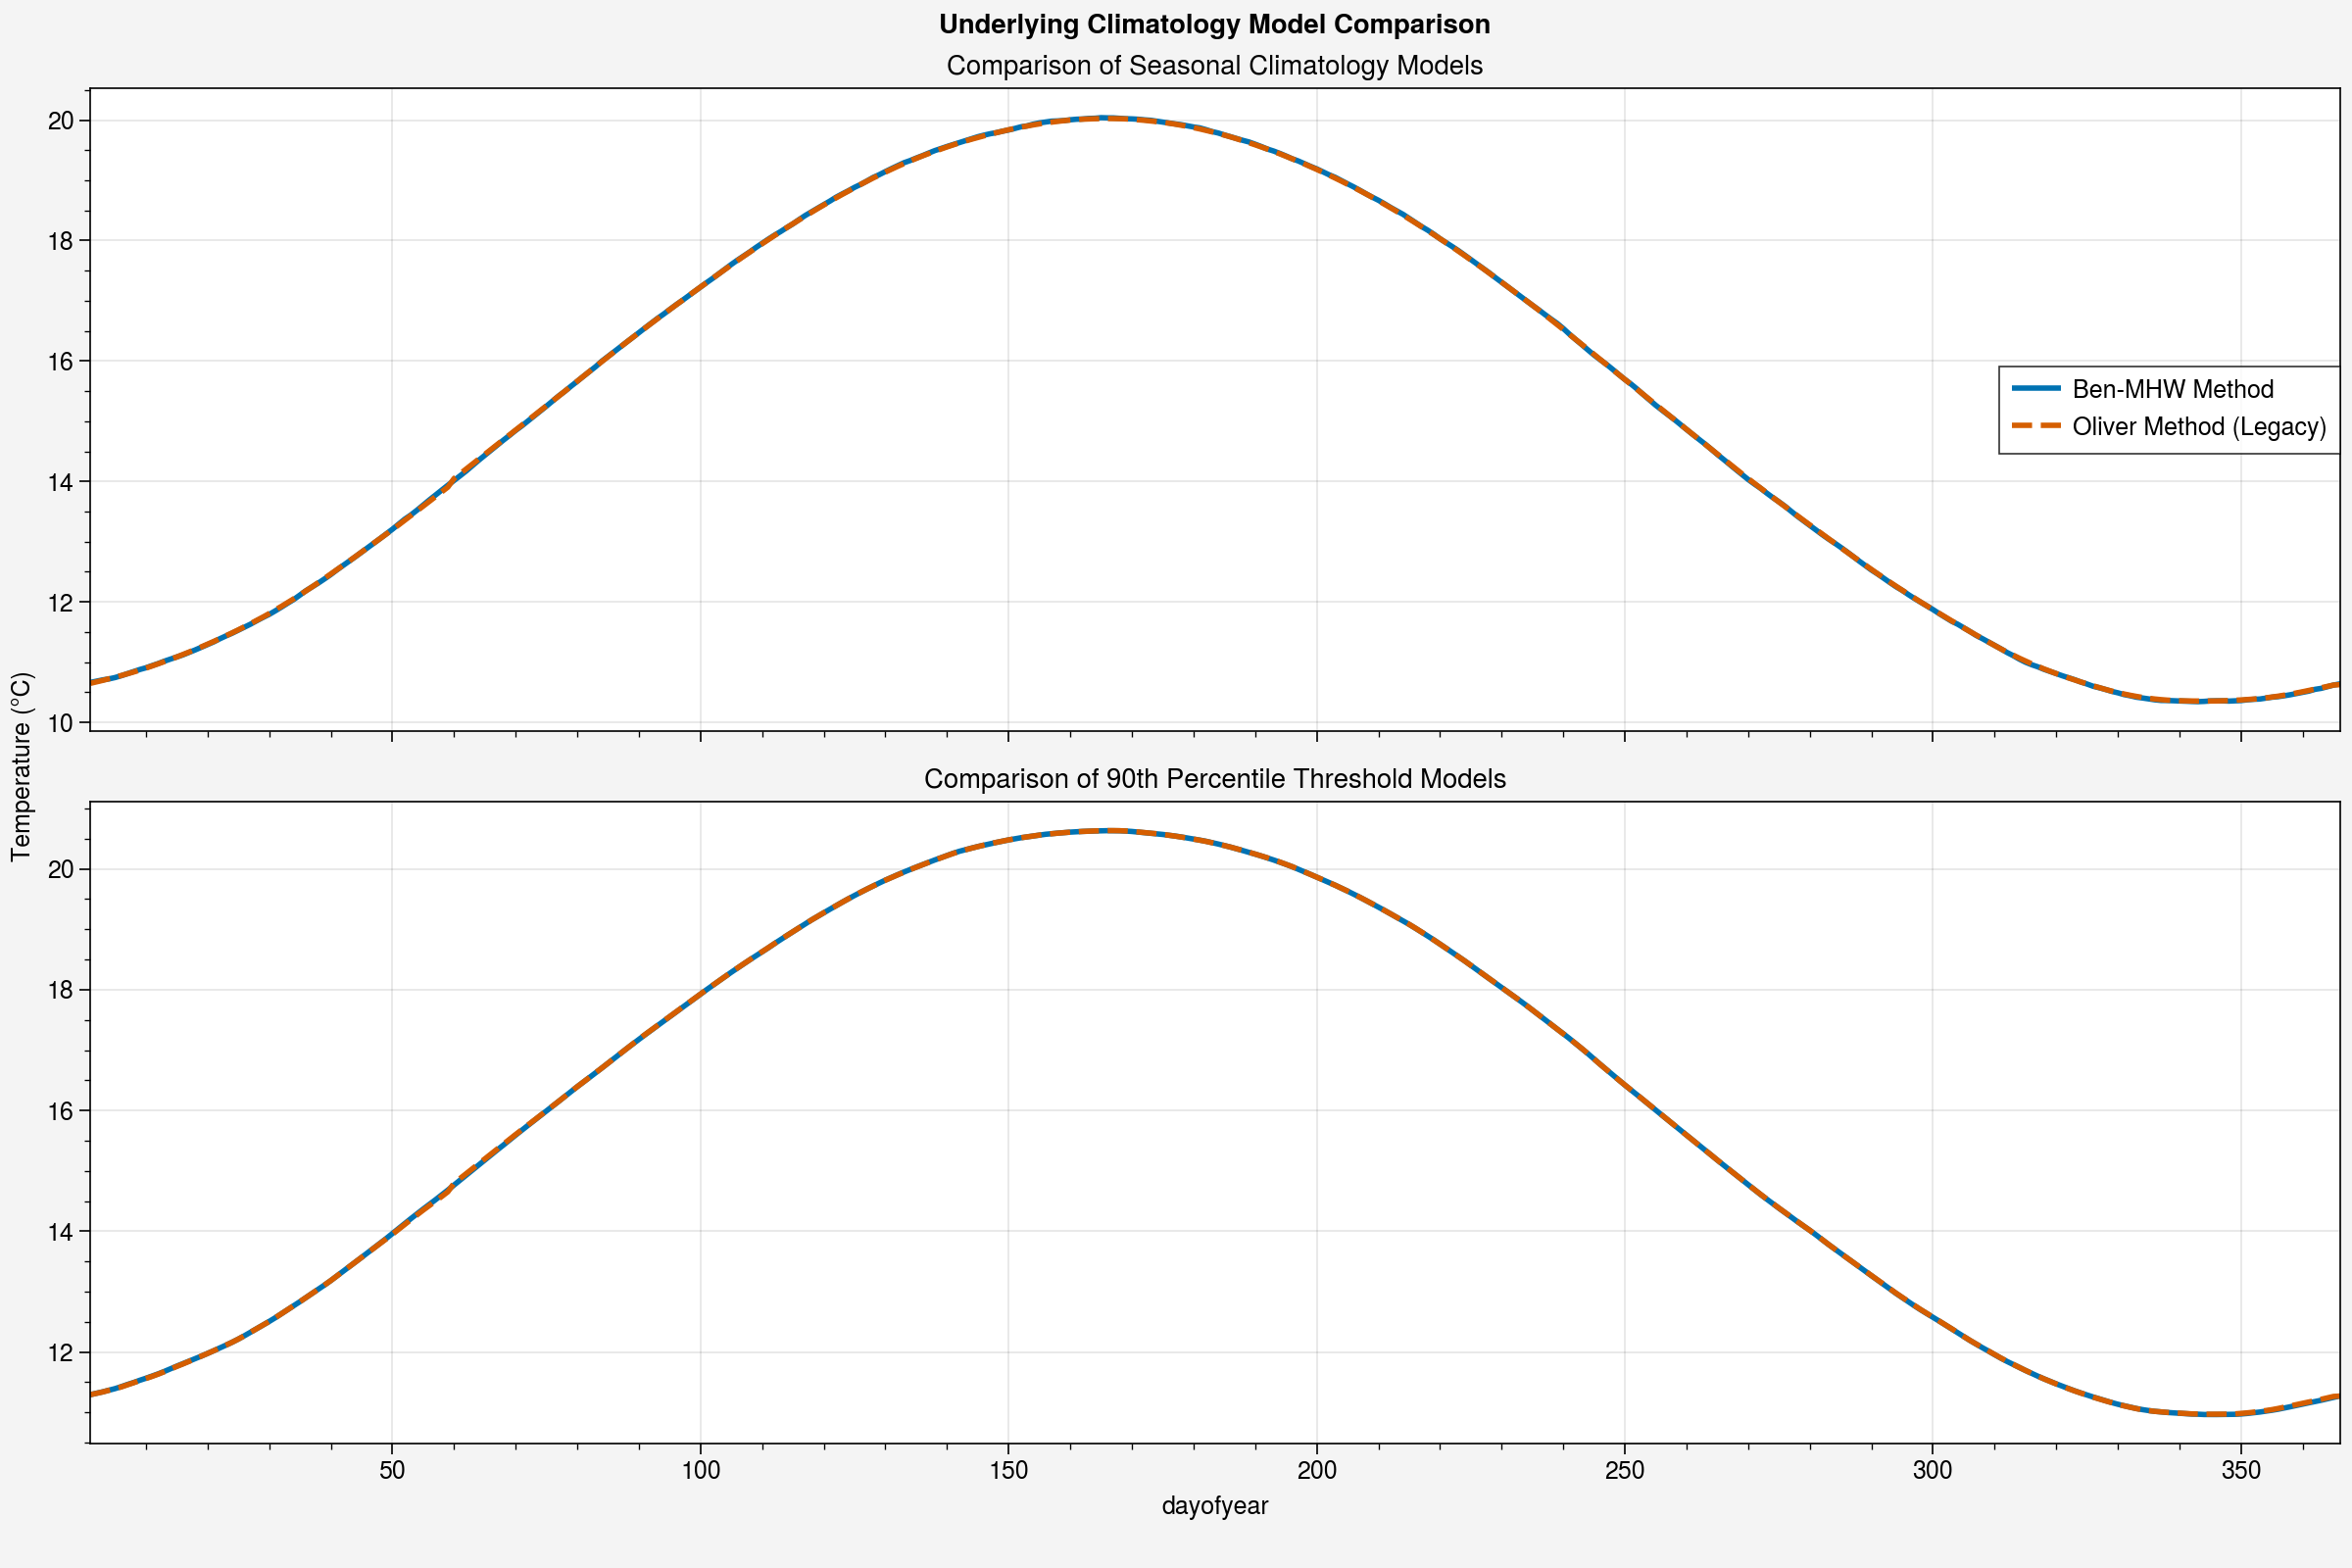

In [6]:
# --- Cell 6: The Correct Climatology Comparison ---

# 1. Calculate the 366-day summary climatology with YOUR ben-mhw code
print("Calculating 366-day climatology using the ben-mhw toolbox...")
ds_for_clim = xr.Dataset(
    data_vars={'temp': (('time',), temp)},
    coords={'time': time}
).expand_dims(['lat', 'lon'])

actual_seas_summary = ben_mhw.smoothedClima_mhw(ds_for_clim.temp).squeeze()
actual_thresh_summary = ben_mhw.smoothedThresh_mhw(ds_for_clim.temp).squeeze()
print("Calculation complete.")


# 2. Convert the Oliver code's DAILY output into a 366-day summary
print("Summarizing the Oliver code's daily output...")
# Create a temporary xarray.DataArray from the Oliver code's daily output
oliver_daily_clim = xr.DataArray(
    expected_clim['seas'], dims=['time'], coords={'time': time}
)
oliver_daily_thresh = xr.DataArray(
    expected_clim['thresh'], dims=['time'], coords={'time': time}
)

# Now, group by day-of-year and average to create the 366-day summary
expected_seas_summary = oliver_daily_clim.groupby('time.dayofyear').mean()
expected_thresh_summary = oliver_daily_thresh.groupby('time.dayofyear').mean()
print("Summarizing complete.")


# 3. Create the definitive comparison plot
fig, axs = uplt.subplots(nrows=2, figsize=(12, 8), tight=True, sharex=True)

# Plot Seasonal Climatologies
axs[0].plot(actual_seas_summary, lw=2, label='Ben-MHW Method')
axs[0].plot(expected_seas_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[0].format(
    title='Comparison of Seasonal Climatology Models',
    ylabel='Temperature (°C)'
)
axs[0].legend(ncols=1, loc='best')

# Plot 90th Percentile Thresholds
axs[1].plot(actual_thresh_summary, lw=2, label='Ben-MHW Method')
axs[1].plot(expected_thresh_summary, lw=2, linestyle='--', label='Oliver Method (Legacy)')
axs[1].format(
    title='Comparison of 90th Percentile Threshold Models',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)

fig.format(suptitle='Underlying Climatology Model Comparison')
uplt.show()

In [7]:
actual_seas_summary

<xarray.DataArray 'temp' (dayofyear: 366)> Size: 3kB
array([10.66193545, 10.68286287, 10.70436284, 10.72039122, 10.74309749,
       10.77352811, 10.80777072, 10.84112827, 10.87620933, 10.90481992,
       10.94127673, 10.97513746, 11.01519614, 11.0501643 , 11.08558536,
       11.11901561, 11.16004409, 11.20164457, 11.24563287, 11.28991335,
       11.33515816, 11.38713492, 11.43468335, 11.47967162, 11.52960954,
       11.58012532, 11.63057042, 11.68718686, 11.74089449, 11.79126692,
       11.85072179, 11.91274037, 11.977387  , 12.03968627, 12.11368722,
       12.187117  , 12.25114319, 12.31345762, 12.3820494 , 12.4534987 ,
       12.53108722, 12.60336211, 12.67425181, 12.74939837, 12.8246222 ,
       12.89942387, 12.97642233, 13.05096787, 13.12875437, 13.20569965,
       13.28998901, 13.3731096 , 13.44286024, 13.52271517, 13.60757112,
       13.6923606 , 13.77347593, 13.85395805, 13.93654121, 14.01441762,
       14.09410159, 14.17525623, 14.26230869, 14.35050485, 14.43381978,
       14.51546997, 14.59959232, 14.68408453, 14.7636947 , 14.84677866,
       14.92144492, 15.00327334, 15.08279148, 15.16811361, 15.25014673,
       15.3365912 , 15.42074453, 15.49732308, 15.5819776 , 15.66258888,
       15.7456481 , 15.82538237, 15.90710047, 15.99835812, 16.07553983,
       16.15497755, 16.23521647, 16.31358346, 16.39082665, 16.47066286,
       16.54966743, 16.62670499, 16.70535346, 16.77758702, 16.8541927 ,
       16.9309619 , 17.00229093, 17.07856033, 17.15290875, 17.227689  ,
...
       13.95763057, 13.88694095, 13.80728127, 13.73151279, 13.66124404,
       13.58663407, 13.50274706, 13.42124613, 13.34498495, 13.2675168 ,
       13.19420988, 13.11826895, 13.04631573, 12.97865376, 12.9074555 ,
       12.8336391 , 12.75563528, 12.67853731, 12.60426695, 12.52900529,
       12.46379988, 12.39196839, 12.32073776, 12.25124273, 12.19106094,
       12.12091929, 12.05509826, 11.99372834, 11.93326176, 11.87152943,
       11.80492679, 11.74201318, 11.67899056, 11.62876265, 11.56920931,
       11.50776956, 11.44275451, 11.38968257, 11.33286267, 11.27615741,
       11.22073124, 11.15994915, 11.10755612, 11.04905181, 10.99775427,
       10.95614483, 10.9214755 , 10.87961861, 10.84452204, 10.80871506,
       10.77180434, 10.73924768, 10.70619023, 10.66803221, 10.63523134,
       10.59774224, 10.57282045, 10.54517413, 10.51348741, 10.4897105 ,
       10.46019381, 10.44059724, 10.41649768, 10.40360733, 10.38886342,
       10.37323684, 10.36289649, 10.36200004, 10.35771211, 10.35261204,
       10.34755327, 10.34609901, 10.34304151, 10.34714837, 10.35490061,
       10.35692231, 10.35575519, 10.35185459, 10.35644309, 10.36101403,
       10.37322867, 10.38174316, 10.38603409, 10.40111532, 10.41621842,
       10.42548221, 10.44053561, 10.45784649, 10.47744436, 10.49761937,
       10.51756841, 10.5474824 , 10.56358473, 10.59067594, 10.61830859,
       10.63782814])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [8]:
expected_seas_summary

<xarray.DataArray (dayofyear: 366)> Size: 3kB
array([10.64747451, 10.67137597, 10.69639763, 10.72252976, 10.74848081,
       10.77577929, 10.80496276, 10.83513451, 10.8664058 , 10.90004429,
       10.93524273, 10.97163351, 11.00854239, 11.04652702, 11.08483196,
       11.12478743, 11.16627531, 11.2088184 , 11.25215522, 11.29662923,
       11.34205758, 11.38856257, 11.43648464, 11.48550735, 11.53511045,
       11.58609303, 11.63860051, 11.69225979, 11.74726005, 11.80489784,
       11.86467124, 11.92567287, 11.98775352, 12.05092284, 12.11570504,
       12.18296143, 12.25138328, 12.32061159, 12.39079445, 12.46215226,
       12.53358286, 12.60533789, 12.67804923, 12.75216711, 12.82594768,
       12.90041564, 12.97502955, 13.04991865, 13.124633  , 13.20037485,
       13.27700895, 13.35463679, 13.43241477, 13.51080289, 13.5896126 ,
       13.66868544, 13.74723962, 13.82593538, 13.90563585, 14.04686291,
       14.12739088, 14.20819884, 14.28927102, 14.37014384, 14.45076862,
       14.53117217, 14.61197928, 14.69271106, 14.77321857, 14.8536036 ,
       14.93416955, 15.0142456 , 15.0941426 , 15.17375246, 15.25400787,
       15.33532118, 15.41741329, 15.49991158, 15.58293679, 15.66567548,
       15.74773523, 15.82898866, 15.91025272, 15.99143239, 16.07221351,
       16.1527806 , 16.23307403, 16.31282458, 16.39164531, 16.46978915,
       16.5474613 , 16.62438225, 16.7010535 , 16.77746896, 16.85348104,
       16.92880231, 17.00387062, 17.07871621, 17.15365211, 17.22850271,
...
       13.96854848, 13.89031774, 13.81225523, 13.73477334, 13.65784669,
       13.58137249, 13.50497735, 13.42861508, 13.35321657, 13.27843692,
       13.20310565, 13.1273392 , 13.05182954, 12.9769138 , 12.90244638,
       12.82865704, 12.75580174, 12.68310859, 12.6109062 , 12.53896014,
       12.46712349, 12.39658853, 12.32744821, 12.25953024, 12.19276704,
       12.12691483, 12.06150804, 11.99661904, 11.93340192, 11.87124827,
       11.80889313, 11.74711669, 11.68628687, 11.6258719 , 11.56605414,
       11.50650033, 11.44774062, 11.38979879, 11.33252027, 11.27524421,
       11.21920389, 11.16577985, 11.11445062, 11.06469184, 11.01707516,
       10.97126252, 10.92785327, 10.88614182, 10.84619416, 10.80797288,
       10.77163719, 10.73661085, 10.70236503, 10.66909414, 10.6368042 ,
       10.6052754 , 10.57480094, 10.54546472, 10.51818898, 10.49305914,
       10.46972601, 10.44856256, 10.42976076, 10.41297923, 10.39864059,
       10.38633704, 10.37623424, 10.3682092 , 10.36230163, 10.35798422,
       10.35514786, 10.35358102, 10.35282742, 10.35251858, 10.35339438,
       10.3547309 , 10.35708329, 10.36051084, 10.36545758, 10.3713164 ,
       10.37773863, 10.3851534 , 10.39465746, 10.40576728, 10.41867523,
       10.43337883, 10.44967412, 10.46754698, 10.48725908, 10.50786227,
       10.52878278, 10.55074496, 10.57369084, 10.59623552, 10.61884326,
       10.62451768])
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

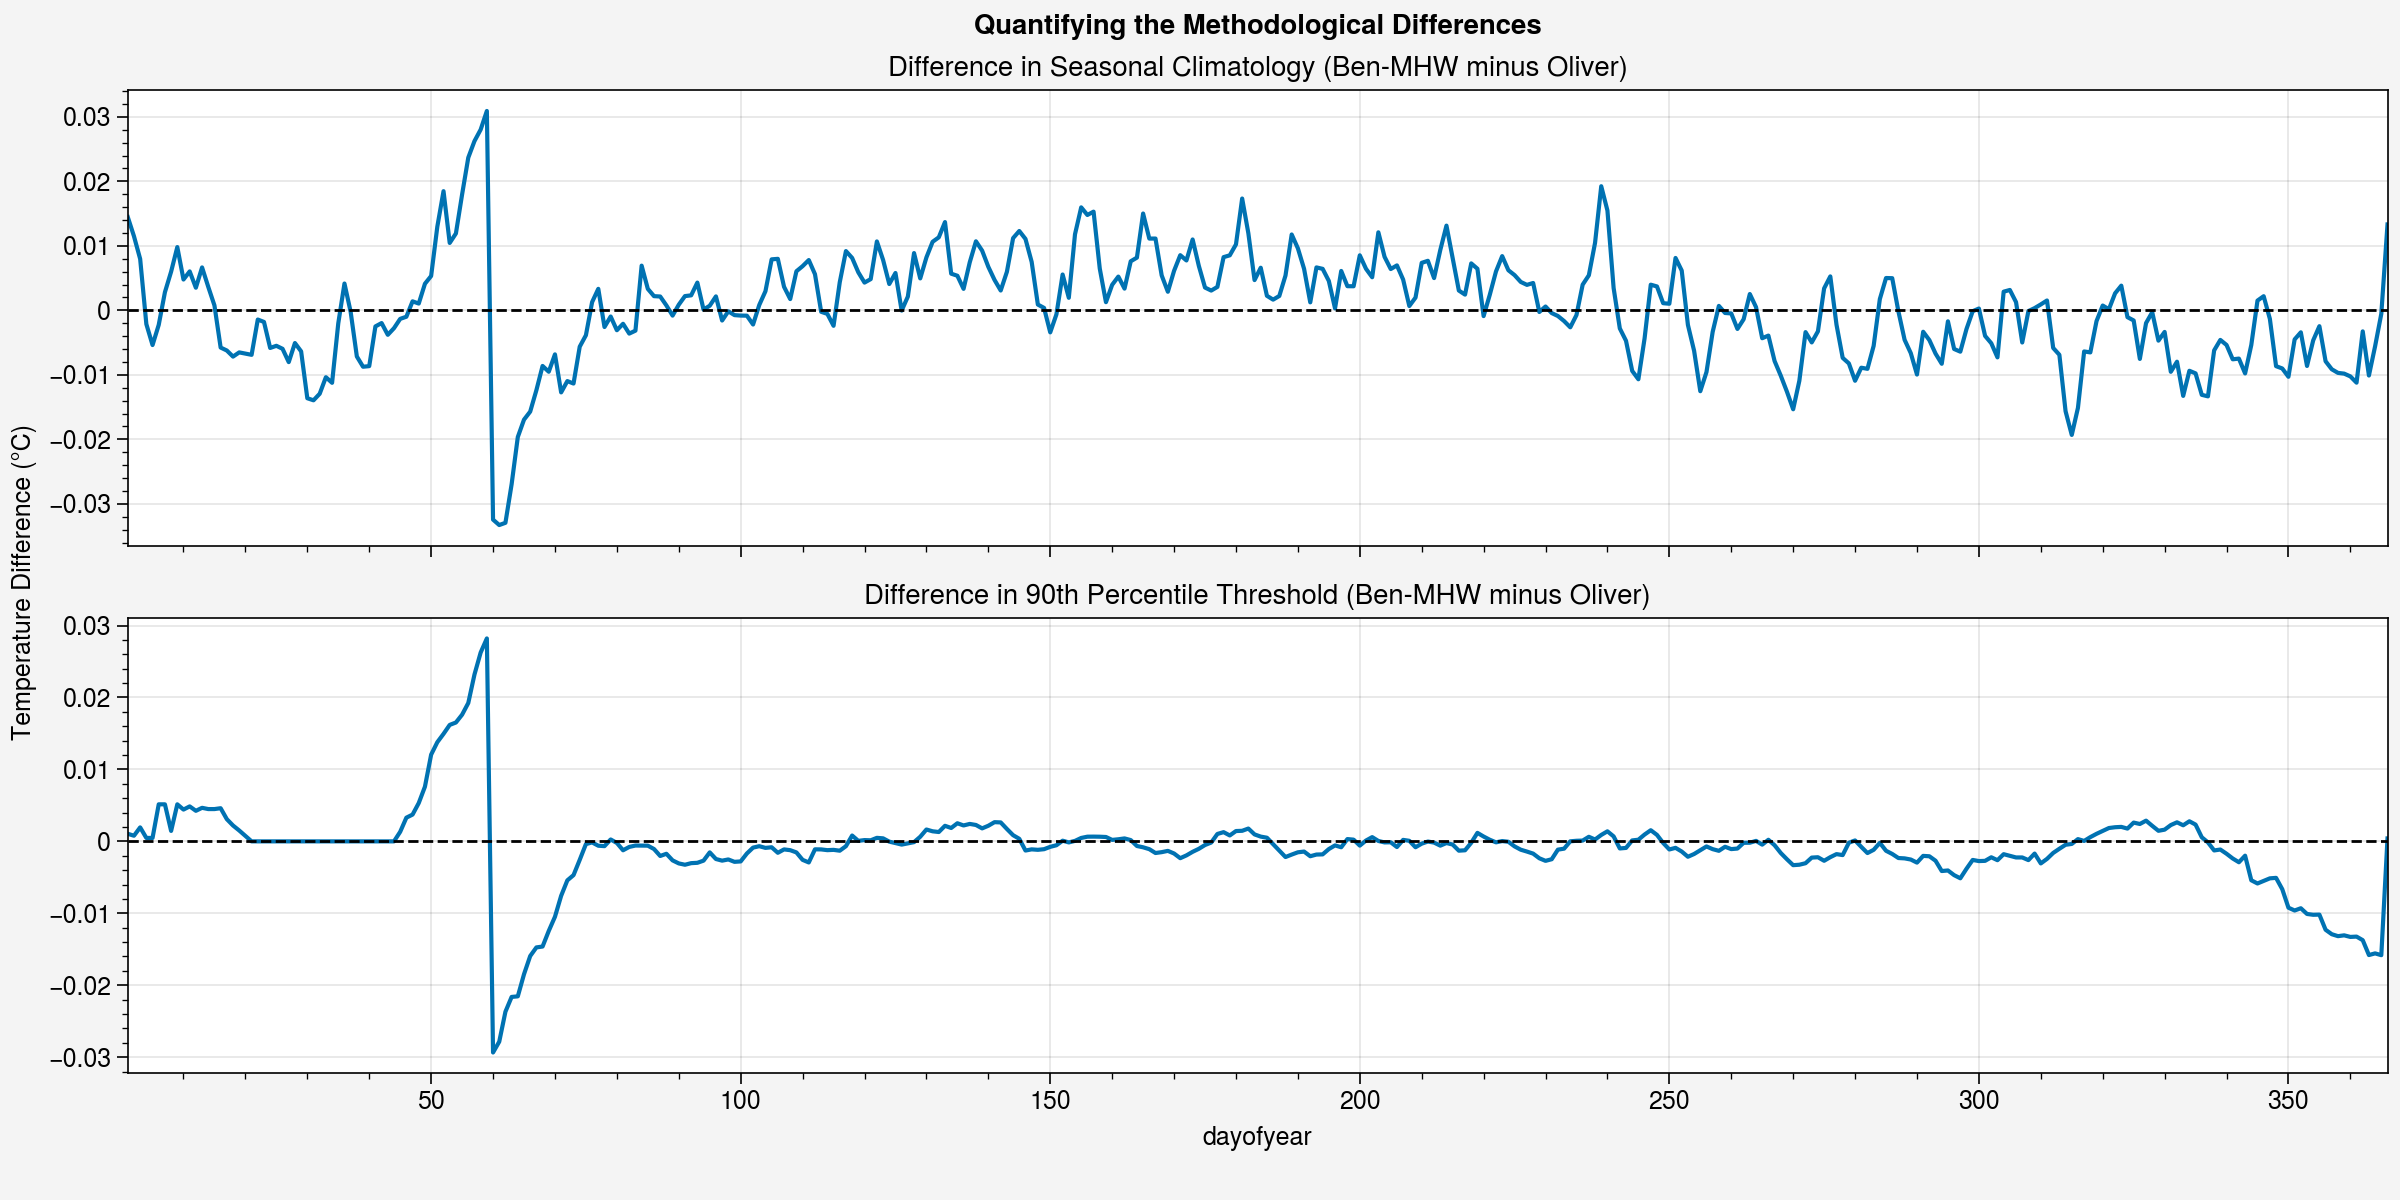

Maximum absolute difference in climatology: 0.0333 °C
Maximum absolute difference in threshold: 0.0293 °C


In [9]:
# --- Cell 7: Numerical Difference Analysis ---

# Calculate the difference between the two climatology models
climatology_difference = actual_seas_summary.values - expected_seas_summary.values

# Calculate the difference between the two threshold models
threshold_difference = actual_thresh_summary.values - expected_thresh_summary.values


# Create a new plot to visualize JUST the difference
fig, axs = uplt.subplots(nrows=2, figsize=(12, 6), tight=True, sharex=True)

# Plot the difference in seasonal climatologies
axs[0].plot(actual_seas_summary.dayofyear, climatology_difference)
axs[0].axhline(0, color='k', linestyle='--', lw=1) # Add a zero line for reference
axs[0].format(
    title='Difference in Seasonal Climatology (Ben-MHW minus Oliver)',
    ylabel='Temperature Difference (°C)'
)

# Plot the difference in 90th percentile thresholds
axs[1].plot(actual_thresh_summary.dayofyear, threshold_difference)
axs[1].axhline(0, color='k', linestyle='--', lw=1)
axs[1].format(
    title='Difference in 90th Percentile Threshold (Ben-MHW minus Oliver)',
    xlabel='Day of Year',
    ylabel='Temperature Difference (°C)'
)

fig.format(suptitle='Quantifying the Methodological Differences')
uplt.show()

# Print the maximum absolute difference to quantify the magnitude
print(f"Maximum absolute difference in climatology: {np.abs(climatology_difference).max():.4f} °C")
print(f"Maximum absolute difference in threshold: {np.abs(threshold_difference).max():.4f} °C")

Calculating RAW (unsmoothed) percentile values for each day-of-year...
Raw value calculation complete.


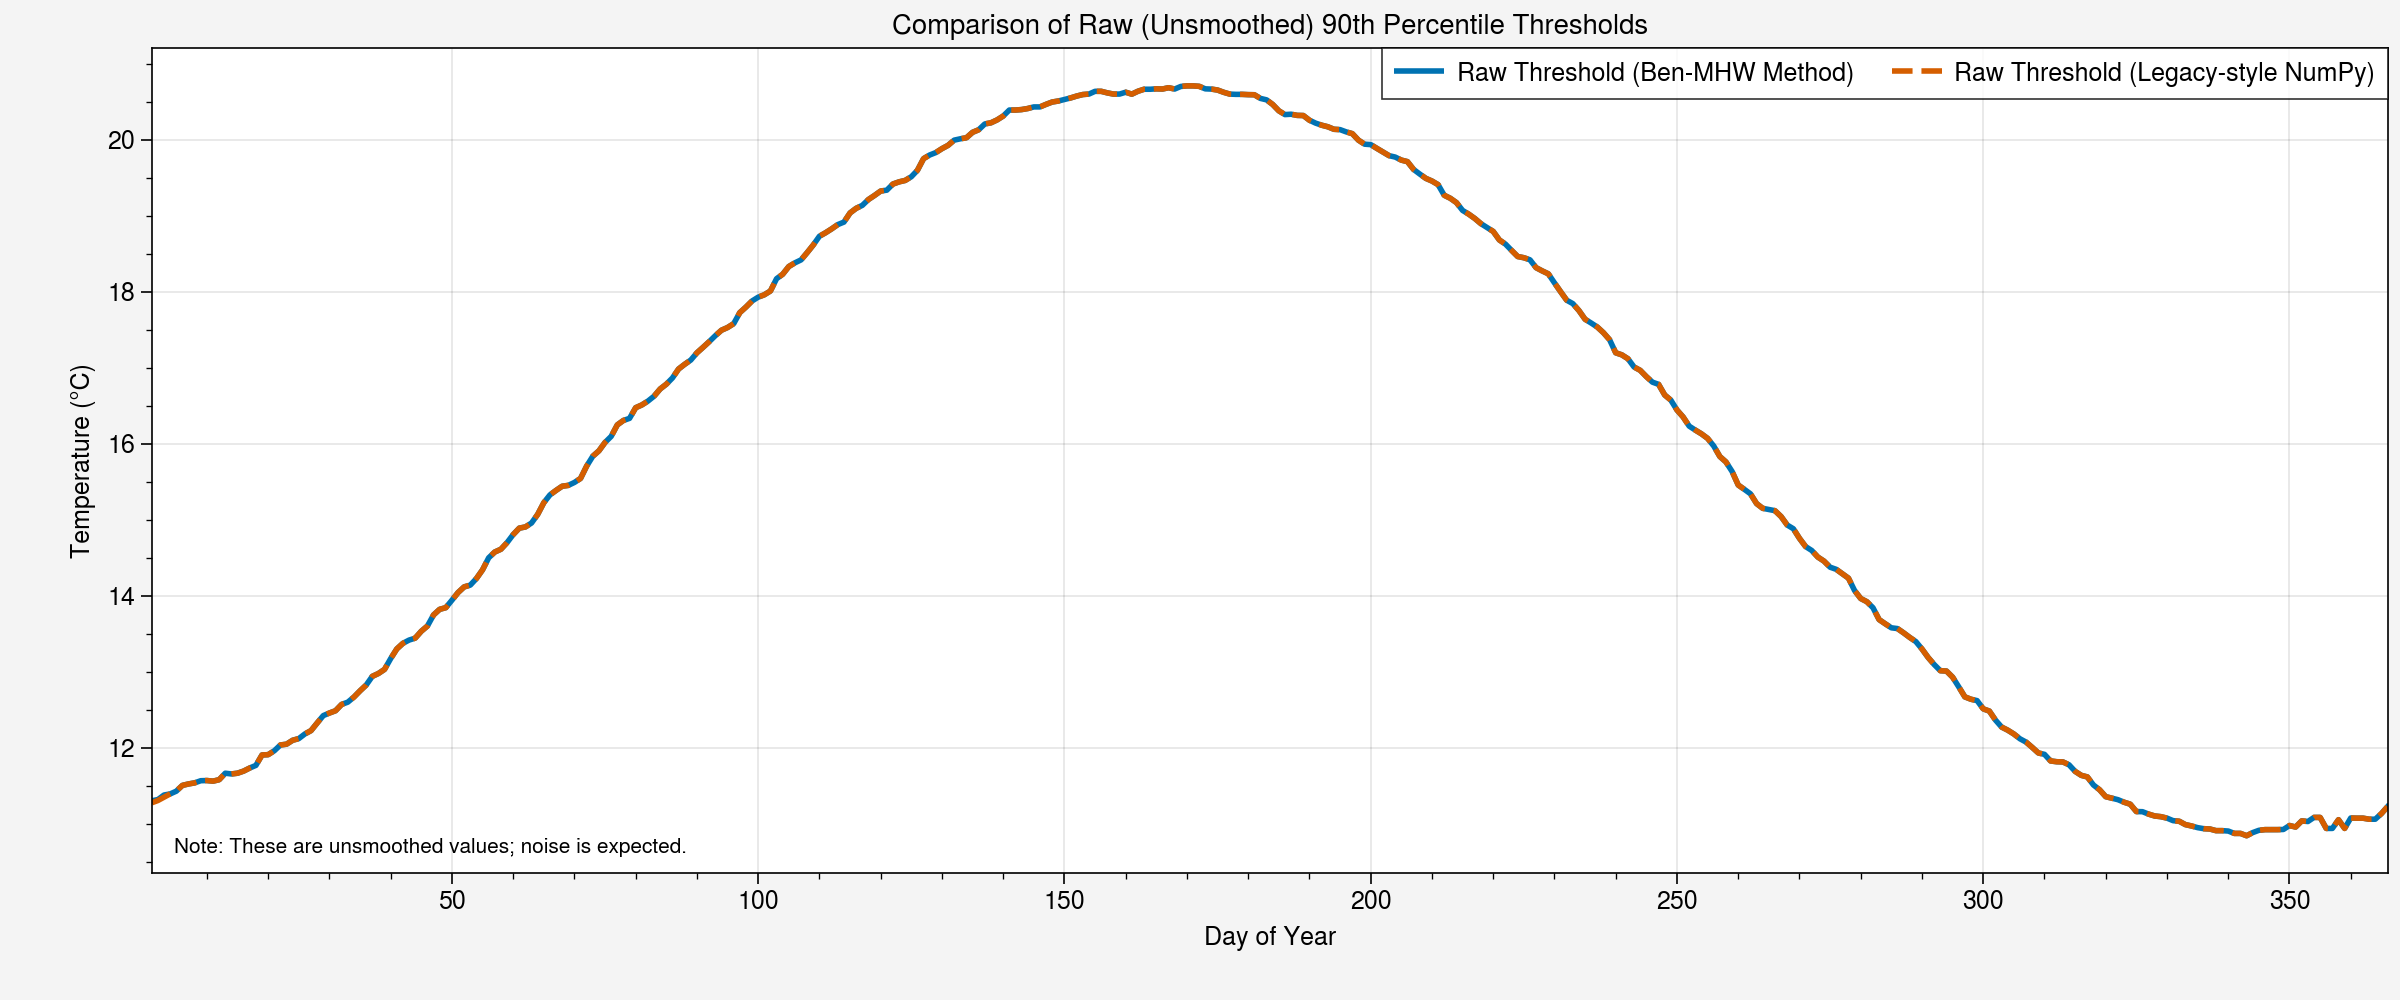

In [10]:
# --- Cell 7: Due Diligence - Raw (Unsmoothed) Threshold Analysis (Corrected) ---

print("Calculating RAW (unsmoothed) percentile values for each day-of-year...")

# We need the dayofyear array from our time coordinate for grouping
doy = ds_for_clim.time.dt.dayofyear

# --- Method 1: Replicate your ben-mhw logic (using xarray) ---
raw_actual_thresh = []
for day in range(1, 367):
    if day <= 366 - 5:
        window = ds_for_clim.temp.where((doy >= day - 5) & (doy <= day + 5), drop=True)
    else:
        window = ds_for_clim.temp.where((doy >= day - 5) | (doy <= (day + 5) % 366), drop=True)
    
    percentile_val = window.quantile(0.9, dim='time', skipna=False)
    raw_actual_thresh.append(percentile_val.item())

# --- Method 2: Replicate the legacy logic (using basic NumPy) ---
raw_expected_thresh = []
temp_np = ds_for_clim.temp.values.flatten()
doy_np = doy.values

for day in range(1, 367):
    days_in_window = np.arange(day - 5, day + 6)
    days_in_window[days_in_window < 1] += 366
    days_in_window[days_in_window > 366] -= 366
    
    indices_in_window = np.isin(doy_np, days_in_window)
    percentile_val = np.percentile(temp_np[indices_in_window], 90)
    raw_expected_thresh.append(percentile_val)

print("Raw value calculation complete.")

# --- Create the comparison plot ---
fig, ax = uplt.subplots(figsize=(12, 5), tight=True)

day_of_year_axis = np.arange(1, 367)
ax.plot(day_of_year_axis, raw_actual_thresh, lw=2, label='Raw Threshold (Ben-MHW Method)')
ax.plot(day_of_year_axis, raw_expected_thresh, lw=2, linestyle='--', label='Raw Threshold (Legacy-style NumPy)')
ax.plot([], [], lw=0)

# The proplot equivalent of 'axes fraction' is just 'axes'
ax.text(0.01, 0.02, 'Note: These are unsmoothed values; noise is expected.', transform='axes', ha='left', va='bottom', fontsize='small') # <--- THIS IS THE CORRECTED LINE

ax.format(
    title='Comparison of Raw (Unsmoothed) 90th Percentile Thresholds',
    xlabel='Day of Year',
    ylabel='Temperature (°C)'
)
ax.legend(loc='best')
uplt.show()